In [1]:
%matplotlib inline

In [98]:
import numpy as np
import os
import csv
import pandas # Should probably have been using pandas and not csv for this from the beginning..
import configparser
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, NullFormatter)
from dataclasses import dataclass


# Simulation directories, with a label that describes the data
sim_dirs = (#('Triggered - 100 ns strobe', '/scratch/ProtonCT/sim_output_pct/run_0'),
            ('Triggered - 5 us strobe', '/scratch/ProtonCT/sim_output_pct/run_1'),
            ('Continuous - 5  us strobe', '/scratch/ProtonCT/sim_output_pct/run_2'),
            #('Triggered - 10 us strobe', '/scratch/ProtonCT/sim_output_pct/run_3'),
            ('Continuous - 10 us strobe', '/scratch/ProtonCT/sim_output_pct/run_4'),
            #('Triggered - 15 us strobe', '/scratch/ProtonCT/sim_output_pct/run_5'),
            ('Continuous - 15 us strobe', '/scratch/ProtonCT/sim_output_pct/run_6'),
            #('Triggered - 20 us strobe', '/scratch/ProtonCT/sim_output_pct/run_7'),
            ('Continuous - 20 us strobe', '/scratch/ProtonCT/sim_output_pct/run_8'),
            #('Triggered - 30 us strobe', '/scratch/ProtonCT/sim_output_pct/run_9'),
            ('Continuous - 30 us strobe', '/scratch/ProtonCT/sim_output_pct/run_10'))
sim_type = "pCT"
sim_additional_title = "1E7 protons/second"
plot_output_dir = '/scratch/ProtonCT/plots'

save_plots = True
print_values = False

# The data in the MC events does not cover the entire pCT plane,
# some links appear to not have any data.
# Use this variable to exclude the last links that do not have any data
# Set to None if not used...
num_links_per_layer_override = 81

# Number of data rate intervals to skip at beginning and end of simulation
# The idea is that the data rate is likely low at when the simulation is starting and stopping,
# and we don't want to include this in our estimates of data rate.
# Note: the length of a data rate interval is specified by data_output/data_rate_interval_ns in settings.txt
data_rate_intervals_skip = 0

# Create plot output directory
if save_plots:
    if not os.path.exists(plot_output_dir):
        os.makedirs(plot_output_dir)
        
        
@dataclass
class SimDataRates:
    # All fields are stored as dicts where the key is layer number
    
    # Total amount of data and protocol
    layer_total_data_mpbs: dict()
    layer_total_protocol_mpbs: dict()
    
    # Mean data and protocol amount
    layer_link_data_mpbs_mean: dict()
    layer_link_data_mpbs_stddev: dict()
    layer_link_protocol_mpbs_mean: dict()
    layer_link_protocol_mpbs_stddev: dict()
    
    # Total data rate (data+protocol) for a layer (ie. readout unit)
    layer_total_data_rate_mean: dict()
    layer_total_data_rate_stddev: dict()
    
    # Data rate (data+protocol) for a link (averaged over all links in the layer)
    # This is for the peak values of data output for the links, 
    # when the chip is being hit by the beam and it has lots of data to transfer 
    layer_link_high_data_rate_mean: dict()
    layer_link_high_data_rate_stddev: dict()
    
    # Data rate (data+protocol) for a link (averaged over all links in the layer)
    layer_link_avg_data_rate_mean: dict()
    layer_link_avg_data_rate_stddev: dict()


sim_data_all = dict()


for sim_label,dir in sim_dirs:
    # Check config, see how many staves per layer were simulated
    config = configparser.ConfigParser()
    config.read(dir + '/settings.txt')

    sim_layers = config.get('pct', 'layers').strip('"').split(";")
    time_frame_length_ns = config.getint('pct', 'time_frame_length_ns')
    
    num_events = None
    
    # Find out how many events were simulated
    with open(dir + '/simulation_info.txt') as sim_info_file:
        for line in sim_info_file:
            if 'Number of untriggered events simulated: ' in line:
                num_events = int(line.strip('Number of untriggered events simulated: '))
    
    assert num_events != None, 'Error retrieving number of untriggered events from simulation_info.txt'

    sim_time_ns = time_frame_length_ns*num_events
        
    print(sim_time_ns)
    print(sim_layers)
    
    sim_data = SimDataRates(dict(), dict(), dict(), dict(), dict(), dict(), dict(), dict(), dict(), dict(), dict(), dict())
    
    for layer_str in sim_layers:
        layer = int(layer_str)
        
        print('Layer: ' + layer_str)
        
        num_staves_per_layer = config.getint('pct','num_staves_per_layer')    
        num_links_per_stave = 9
        num_links_per_layer = num_links_per_stave * num_staves_per_layer
        
        if num_links_per_layer_override is not None:
            num_links_per_layer = num_links_per_layer_override
        
        data_mpbs_per_link_arr = np.zeros(num_links_per_layer)
        protocol_mpbs_per_link_arr = np.zeros(num_links_per_layer)
        
        # Open link utilization file for current layer/RU
        with open(dir + '/RU_' + layer_str + '_0_Link_utilization.csv') as csv_file:
            csv_reader = csv.DictReader(csv_file, delimiter=';')
            link_num = 0
            for row in csv_reader:
                if link_num < num_links_per_layer:
                    data_bytes = int(row['DATA_SHORT (bytes)']) + \
                                 int(row['DATA_LONG (bytes)']) + \
                                 int(row['REGION_HEADER (bytes)'])
                    
                    protocol_bytes = int(row['CHIP_HEADER (bytes)']) + \
                                     int(row['CHIP_TRAILER (bytes)']) + \
                                     int(row['CHIP_EMPTY_FRAME (bytes)']) + \
                                     int(row['BUSY_ON (bytes)']) + \
                                     int(row['BUSY_OFF (bytes)'])
                    
                    data_mpbs_per_link_arr[link_num] = (data_bytes*8)*1E9/(sim_time_ns*1E6)
                    protocol_mpbs_per_link_arr[link_num] = (protocol_bytes*8)*1E9/(sim_time_ns*1E6)
                    link_num += 1
        
        # Mean data per link per layer
        sim_data.layer_link_data_mpbs_mean[layer] = np.mean(data_mpbs_per_link_arr)                        
        sim_data.layer_link_data_mpbs_stddev[layer] = np.std(data_mpbs_per_link_arr)
        sim_data.layer_link_protocol_mpbs_mean[layer] = np.mean(protocol_mpbs_per_link_arr)                        
        sim_data.layer_link_protocol_mpbs_stddev[layer] = np.std(protocol_mpbs_per_link_arr)
        
        # Total data per layer/RU
        sim_data.layer_total_data_mpbs[layer] = np.sum(data_mpbs_per_link_arr)
        sim_data.layer_total_protocol_mpbs[layer] = np.sum(protocol_mpbs_per_link_arr)
        
        
        # Open data rate file for current layer/RU
        with open(dir + '/RU_' + layer_str + '_0_Data_rate.csv') as csv_file:
            csv_data = pandas.read_csv(csv_file, delimiter=';')
            
            #csv_reader = csv.DictReader(csv_file, delimiter=';')
            #row_count = len(list(csv_reader))
            
            # Yes there is a space before 'RU' in the header name... :(
            layer_total_data_rate_list = csv_data[' RU total (Mbps)']
            
            sim_data.layer_total_data_rate_mean[layer] = np.mean(layer_total_data_rate_list)
            sim_data.layer_total_data_rate_stddev[layer] = np.std(layer_total_data_rate_list)
            
            
            
            data_rate_mean_per_link_arr = np.zeros(num_links_per_layer)            
            data_rate_high_per_link_arr = np.zeros(num_links_per_layer)
            
            for link_num in range(0,num_links_per_layer):
                column_name = 'Link ' + str(link_num) + ' (Mbps)'
                link_data_rate_list = csv_data[column_name]
                data_rate_mean_per_link_arr[link_num] = np.mean(link_data_rate_list)
                data_rate_high_per_link_arr[link_num] = np.max(link_data_rate_list)
            
            sim_data.layer_link_avg_data_rate_mean[layer] = np.mean(data_rate_mean_per_link_arr)
            sim_data.layer_link_avg_data_rate_stddev[layer] = np.std(data_rate_mean_per_link_arr)
            sim_data.layer_link_high_data_rate_mean[layer] = np.mean(data_rate_high_per_link_arr)
            sim_data.layer_link_high_data_rate_stddev[layer] = np.std(data_rate_high_per_link_arr)
        
        
    sim_data_all[sim_label] = sim_data


64320000
['0', '5', '10', '15', '20', '25', '30', '35', '40']
Layer: 0
Layer: 5
Layer: 10
Layer: 15
Layer: 20


Layer: 25
Layer: 30
Layer: 35
Layer: 40
64320000
['0', '5', '10', '15', '20', '25', '30', '35', '40']
Layer: 0


Layer: 5
Layer: 10
Layer: 15
Layer: 20
Layer: 25


Layer: 30
Layer: 35
Layer: 40
64320000
['0', '5', '10', '15', '20', '25', '30', '35', '40']
Layer: 0
Layer: 5
Layer: 10


Layer: 15
Layer: 20
Layer: 25
Layer: 30
Layer: 35
Layer: 40


64320000
['0', '5', '10', '15', '20', '25', '30', '35', '40']
Layer: 0
Layer: 5
Layer: 10
Layer: 15
Layer: 20
Layer: 25
Layer: 30


Layer: 35
Layer: 40
64320000
['0', '5', '10', '15', '20', '25', '30', '35', '40']
Layer: 0
Layer: 5
Layer: 10
Layer: 15
Layer: 20


Layer: 25
Layer: 30
Layer: 35
Layer: 40
64320000
['0', '5', '10', '15', '20', '25', '30', '35', '40']
Layer: 0
Layer: 5
Layer: 10


Layer: 15
Layer: 20
Layer: 25
Layer: 30
Layer: 35
Layer: 40


dict_items([(0, 13.06031877648793), (5, 12.591424052576622), (10, 12.08887814016338), (15, 11.567520422578465), (20, 11.049795774215342), (25, 10.553361280019654), (30, 10.073048338554143), (35, 9.585487685031632), (40, 8.81021743136171)])
<class 'tuple'>
(0, 5, 10, 15, 20, 25, 30, 35, 40)
<class 'numpy.ndarray'>
dict_items([(0, 13.204555924083285), (5, 12.633141391806399), (10, 12.082025059885758), (15, 11.558145998403045), (20, 11.045127756280326), (25, 10.55141576070266), (30, 10.072616854001597), (35, 9.58538326884098), (40, 8.810177507524108)])
<class 'tuple'>
(0, 5, 10, 15, 20, 25, 30, 35, 40)
<class 'numpy.ndarray'>
dict_items([(0, 9.87430901050304), (5, 9.432161722252932), (10, 9.008944475155086), (15, 8.600348565812912), (20, 8.216044776119404), (25, 7.847816473189607), (30, 7.489332657699158), (35, 7.123616485473866), (40, 6.559300718629076)])
<class 'tuple'>
(0, 5, 10, 15, 20, 25, 30, 35, 40)
<class 'numpy.ndarray'>
dict_items([(0, 8.731060745654444), (5, 8.337803267612555),

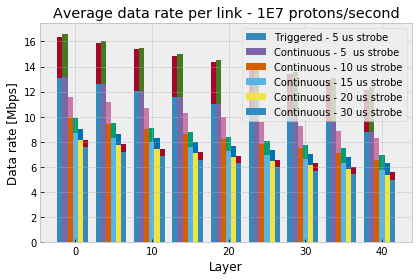

In [99]:
# Plot data rate per link

fig, ax = plt.subplots()

#plt.style.use('ggplot')
#plt.style.use('seaborn-paper')
plt.style.use('bmh')

width = (5.0/len(sim_data_all)) * 0.8

plots_data = dict()
plots_protocol = dict()


plot_error_bars = False


plot_num = 0
for sim_label in sim_data_all:
    list_layer_link_data_mean = sorted(sim_data_all[sim_label].layer_link_data_mpbs_mean.items())
    list_layer_link_data_stddev = sorted(sim_data_all[sim_label].layer_link_data_mpbs_stddev.items())
    list_layer_link_protocol_mean = sorted(sim_data_all[sim_label].layer_link_protocol_mpbs_mean.items())
    list_layer_link_protocol_stddev = sorted(sim_data_all[sim_label].layer_link_protocol_mpbs_stddev.items())

    print(sim_data_all[sim_label].layer_link_data_mpbs_mean.items())

    layers, data_mean = zip(*list_layer_link_data_mean)
    layers, data_stddev = zip(*list_layer_link_data_stddev)
    layers, protocol_mean = zip(*list_layer_link_protocol_mean)
    layers, protocol_stddev = zip(*list_layer_link_protocol_stddev)
    
    print(type(layers))
    print(layers)
    
    layers_arr = np.array(layers)
    
    print(type(layers_arr))
    
    bar_position = (plot_num-len(sim_data_all)/2)*width

    if plot_error_bars:    
        plots_data[sim_label] = plt.bar(layers_arr + bar_position, data_mean, width,
                                        yerr=data_stddev, label=sim_label)
    
        plots_protocol[sim_label] = plt.bar(layers_arr + bar_position, protocol_mean, width,
                                             bottom=data_mean, yerr=protocol_stddev)
    else:
        plots_data[sim_label] = plt.bar(layers_arr + bar_position, data_mean, width, label=sim_label)
    
        plots_protocol[sim_label] = plt.bar(layers_arr + bar_position, protocol_mean, width, bottom=data_mean)

    plot_num += 1


additional_title = ''
if len(sim_additional_title) > 0:
    additional_title = ' - ' + sim_additional_title

#ax.set_yscale('log')
plt.title('Average data rate per link' + additional_title)
plt.xlabel('Layer')
plt.ylabel('Data rate [Mbps]')
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend()


#ax.yaxis.set_major_locator(MultipleLocator(100))
#ax.yaxis.grid(True, which='minor')
#ax.yaxis.set_minor_locator(MultipleLocator(50))

plt.tight_layout()

if save_plots:
    fig.savefig(plot_output_dir + '/data_rates_per_link.png', bbox_inches='tight')
    fig.savefig(plot_output_dir + '/data_rates_per_links.pdf', bbox_inches='tight')
plt.show()
plt.close(fig)



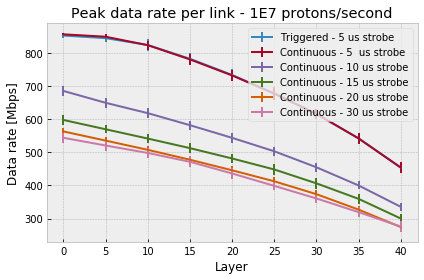

In [101]:
# Plot data rate per link

fig, ax = plt.subplots()

#plt.style.use('ggplot')
#plt.style.use('seaborn-paper')
plt.style.use('bmh')

width = (5.0/len(sim_data_all)) * 0.8

plots_data = dict()
plots_protocol = dict()


plot_error_bars = True
plot_bar_plot = False


plot_num = 0
for sim_label in sim_data_all:
    list_layer_link_high_data_rate_mean = sorted(sim_data_all[sim_label].layer_link_high_data_rate_mean.items())
    list_layer_link_high_data_rate_stddev = sorted(sim_data_all[sim_label].layer_link_high_data_rate_stddev.items())

    layers, data_mean = zip(*list_layer_link_high_data_rate_mean)
    layers, data_stddev = zip(*list_layer_link_high_data_rate_stddev)
    
    layers_arr = np.array(layers)
       
    bar_position = (plot_num-len(sim_data_all)/2)*width

    if plot_bar_plot:
        if plot_error_bars:    
            plots_data[sim_label] = plt.bar(layers_arr + bar_position, data_mean, width,
                                            yerr=data_stddev, label=sim_label)
        else:
            plots_data[sim_label] = plt.bar(layers_arr + bar_position, data_mean, width, label=sim_label)
    else:
        if plot_error_bars:    
            plots_data[sim_label] = plt.errorbar(layers_arr, data_mean, yerr=data_stddev, label=sim_label)
        else:
            plots_data[sim_label] = plt.plot(layers_arr, data_mean, label=sim_label)

    plot_num += 1


additional_title = ''
if len(sim_additional_title) > 0:
    additional_title = ' - ' + sim_additional_title

#ax.set_yscale('log')
plt.title('Peak data rate per link' + additional_title)
plt.xlabel('Layer')
plt.ylabel('Data rate [Mbps]')
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend()


#ax.yaxis.set_major_locator(MultipleLocator(100))
#ax.yaxis.grid(True, which='minor')
#ax.yaxis.set_minor_locator(MultipleLocator(50))

plt.tight_layout()

if save_plots:
    fig.savefig(plot_output_dir + '/data_rates_peak_per_link.png', bbox_inches='tight')
    fig.savefig(plot_output_dir + '/data_rates_peak_per_links.pdf', bbox_inches='tight')
plt.show()
plt.close(fig)




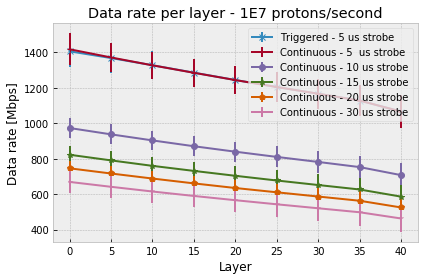

In [102]:
# Plot data rate per link

import itertools
marker = itertools.cycle(('x', '+', 'o', '*', 'p', '1', '2', 'X', 'D')) 


fig = plt.figure(1)

#plt.style.use('ggplot')
#plt.style.use('seaborn-paper')
plt.style.use('bmh')

plots_data = dict()
plot_error_bars = True

for sim_label in sim_data_all:
    list_layer_total_data_rate_mean = sorted(sim_data_all[sim_label].layer_total_data_rate_mean.items())
    list_layer_total_data_rate_stddev = sorted(sim_data_all[sim_label].layer_total_data_rate_stddev.items())

    layers, data_mean = zip(*list_layer_total_data_rate_mean)
    layers, data_stddev = zip(*list_layer_total_data_rate_stddev)    
    layers_arr = np.array(layers)

    if plot_error_bars:    
        plots_data[sim_label] = plt.errorbar(layers_arr, data_mean, yerr=data_stddev, label=sim_label, marker=next(marker))
    else:
        plots_data[sim_label] = plt.plot(layers_arr, data_mean, label=sim_label, marker=next(marker))


additional_title = ''
if len(sim_additional_title) > 0:
    additional_title = ' - ' + sim_additional_title

#ax.set_yscale('log')
plt.title('Data rate per layer' + additional_title)
plt.xlabel('Layer')
plt.ylabel('Data rate [Mbps]')
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend(loc='upper right')


#ax.yaxis.set_major_locator(MultipleLocator(100))
#ax.yaxis.grid(True, which='minor')
#ax.yaxis.set_minor_locator(MultipleLocator(50))

plt.tight_layout()

if save_plots:
    fig.savefig(plot_output_dir + '/data_rates_per_layer.png', bbox_inches='tight', edgecolor='none')
    fig.savefig(plot_output_dir + '/data_rates_per_layer.pdf', bbox_inches='tight', edgecolor='none')
    
    
plt.show()
plt.close(fig)


